In [ ]:
import os

# נתיב התיקייה שבה נמצאים הקבצים
folder_path = "/content"

# פונקציה לשינוי שם הקובץ לפורמט אחיד
def rename_file(file_path, filename):
    # פיצול השם לחלקים
    name, ext = os.path.splitext(filename)
    parts = name.split("_")

    # חילוץ השם והדיליי
    if len(parts) >= 2:
        experimenter = parts[0]  # שם הנסיין
        delay = parts[-1].replace("d", "ms")  # המרת "d" ל-"ms"
        new_name = f"{experimenter}_{delay}{ext}"  # שם חדש בפורמט אחיד
    else:
        new_name = filename  # אם השם לא בפורמט המתאים, משאירים אותו כמו שהוא

    # מסלול חדש לקובץ
    new_file_path = os.path.join(folder_path, new_name)

    # הדפסת שם הקובץ המקורי והשם החדש
    print(f"Original: {filename} -> New: {new_name}")

    # שינוי השם
    os.rename(file_path, new_file_path)

# קריאת הקבצים בתיקייה
files = [filename for filename in os.listdir(folder_path) if filename.endswith(".mat")]

# מיון הקבצים לפי שם הנסיין והדיליי
def extract_key(filename):
    name, ext = os.path.splitext(filename)
    parts = name.split("_")
    experimenter = parts[0]
    delay = parts[-1].replace("d", "").replace("ms", "")
    return experimenter, float(delay)

sorted_files = sorted(files, key=extract_key)

# מעבר על הקבצים אחרי המיון ושינוי שמות
print("\nProcessing sorted files in directory:", folder_path)
for filename in sorted_files:
    file_path = os.path.join(folder_path, filename)
    rename_file(file_path, filename)



Processing sorted files in directory: /content
Original: maayan_0.2ms.mat -> New: maayan_0.2ms.mat
Original: maayan_1.1ms.mat -> New: maayan_1.1ms.mat
Original: maayan_2ms.mat -> New: maayan_2ms.mat
Original: maayan_11ms.mat -> New: maayan_11ms.mat
Original: maayan_20ms.mat -> New: maayan_20ms.mat
Original: maayan_60ms.mat -> New: maayan_60ms.mat
Original: maayan_110ms.mat -> New: maayan_110ms.mat
Original: maayan_200ms.mat -> New: maayan_200ms.mat
Original: zohar_0.4ms.mat -> New: zohar_0.4ms.mat
Original: zohar_1.2ms.mat -> New: zohar_1.2ms.mat
Original: zohar_2ms.mat -> New: zohar_2ms.mat
Original: zohar_12ms.mat -> New: zohar_12ms.mat
Original: zohar_20ms.mat -> New: zohar_20ms.mat
Original: zohar_60ms.mat -> New: zohar_60ms.mat
Original: zohar_120ms.mat -> New: zohar_120ms.mat
Original: zohar_200ms.mat -> New: zohar_200ms.mat



=== Processing for Participant 1 (Maayan) ===
Processing file: /content/maayan_0.2ms.mat
Processing file: /content/maayan_20ms.mat
Processing file: /content/maayan_200ms.mat

=== Processing for Participant 2 (Zohar) ===
Processing file: /content/zohar_0.4ms.mat
Processing file: /content/zohar_20ms.mat
Processing file: /content/zohar_200ms.mat


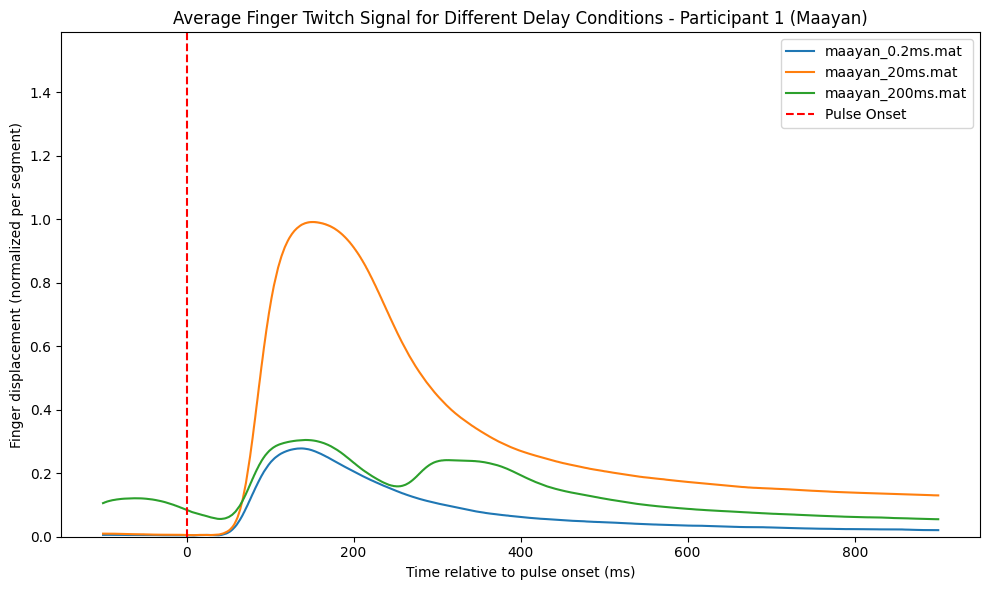

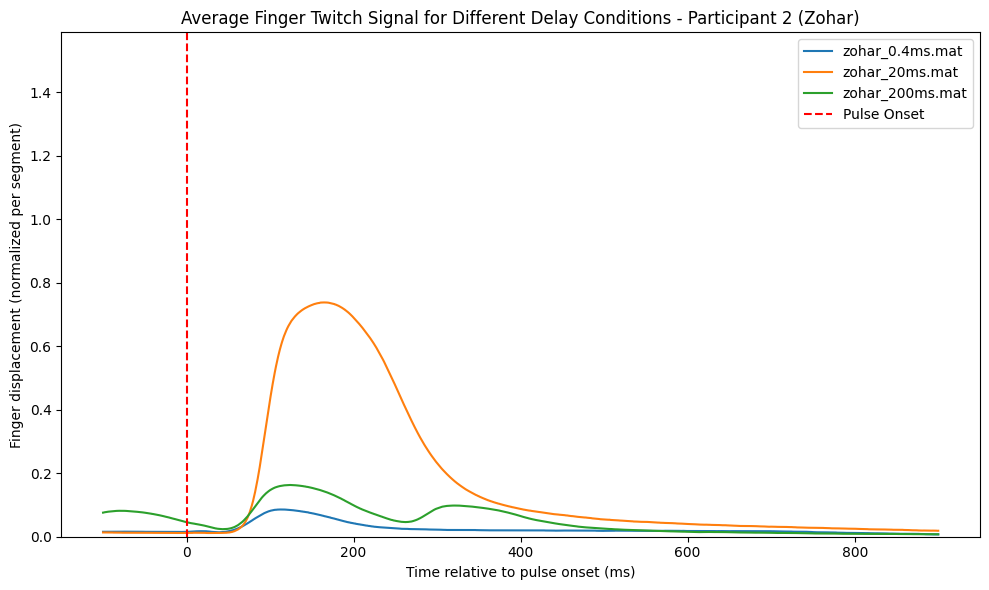

In [ ]:
import os
import re
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

def extract_delay(file_path):
    """
    Extracts the delay value from the filename.
    Assumes the filename contains a pattern like '_0.2ms'.
    """
    base_name = os.path.splitext(os.path.basename(file_path))[0]
    parts = base_name.split('_')
    if len(parts) < 2:
        return float('inf')
    delay_str = parts[-1]
    numeric_str = re.sub(r'[^0-9\.\-]', '', delay_str)
    try:
        return float(numeric_str)
    except ValueError:
        return float('inf')

def load_mat_file(file_path):
    """
    Loads a .mat file and handles compatibility issues with different formats.
    """
    try:
        return sio.loadmat(file_path, squeeze_me=True, struct_as_record=False)
    except NotImplementedError:
        print(f"Failed to load {file_path}: Unsupported .mat file format.")
        return None

def process_and_plot(files_to_process, threshold=5.0, pre_ms=100, post_ms=900, min_gap_ms=200):
    """
    Processes files and generates plots for each participant.
    """
    global_min = float('inf')
    global_max = float('-inf')

    all_data = {}

    for participant, file_paths in files_to_process.items():
        print(f"\n=== Processing for {participant} ===")

        all_segments = []
        all_labels = []

        for file_path in file_paths:
            print(f"Processing file: {file_path}")

            mat_dict = load_mat_file(file_path)
            if mat_dict is None:
                print(f"-> Failed to load {file_path}. Skipping.")
                continue

            raw_data = mat_dict.get('data', None)
            labels = mat_dict.get('labels', None)
            isi = mat_dict.get('isi', None)

            if raw_data is None or not isinstance(raw_data, np.ndarray):
                print("-> No 'data' found or data not ndarray. Skipping.")
                continue

            if isinstance(labels, np.ndarray):
                labels = labels.tolist()
            elif isinstance(labels, str):
                labels = [labels]

            col_analog, col_finger = None, None
            if labels:
                for col_idx, lbl in enumerate(labels):
                    lbl_lower = str(lbl).lower().strip()
                    if 'analog' in lbl_lower or 'emg' in lbl_lower:
                        col_analog = col_idx
                    elif 'finger' in lbl_lower:
                        col_finger = col_idx

            if (col_analog is None or col_finger is None) and raw_data.shape[1] == 2:
                col_analog = 0
                col_finger = 1

            if col_analog is None or col_finger is None:
                print("-> Could not identify analog/finger columns. Skipping.")
                continue

            analog_data = raw_data[:, col_analog]
            finger_data = raw_data[:, col_finger]

            if isi is not None:
                isi_val = isi.item() if isinstance(isi, np.ndarray) else isi
                time = np.arange(raw_data.shape[0]) * isi_val
            else:
                isi_val = 1.0
                time = np.arange(raw_data.shape[0])

            min_gap_samples = int(min_gap_ms / isi_val)
            pulse_indices = np.where(np.diff(analog_data > threshold, prepend=False) > 0)[0]

            filtered_pulse_indices = []
            for idx in pulse_indices:
                if not filtered_pulse_indices or (idx - filtered_pulse_indices[-1] >= min_gap_samples):
                    filtered_pulse_indices.append(idx)

            pre_samples = int(pre_ms / isi_val)
            post_samples = int(post_ms / isi_val)
            segment_length = pre_samples + post_samples

            for pulse_onset_idx in filtered_pulse_indices:
                start_idx = max(pulse_onset_idx - pre_samples, 0)
                end_idx = min(pulse_onset_idx + post_samples, len(time)-1)

                seg_finger = finger_data[start_idx:end_idx]

                if len(seg_finger) != segment_length:
                    continue

                seg_finger = seg_finger - np.min(seg_finger)
                global_min = min(global_min, np.min(seg_finger))
                global_max = max(global_max, np.max(seg_finger))

                all_segments.append(seg_finger)
                all_labels.append(os.path.basename(file_path))

        all_data[participant] = (all_segments, all_labels)

    for participant, (all_segments, all_labels) in all_data.items():
        unique_labels = sorted(set(all_labels), key=lambda x: extract_delay(x))

        plt.figure(figsize=(10, 6))
        plt.title(f"Average Finger Twitch Signal for Different Delay Conditions - {participant}")

        for label in unique_labels:
            segments = [seg for seg, lbl in zip(all_segments, all_labels) if lbl == label]
            avg_signal = np.mean(segments, axis=0)

            time_axis = np.linspace(-pre_ms, post_ms, segment_length)
            plt.plot(time_axis, avg_signal, label=label)

        plt.axvline(x=0, color='r', linestyle='--', label='Pulse Onset')
        plt.legend()
        plt.ylim(global_min, global_max)
        plt.xlabel("Time relative to pulse onset (ms)")
        plt.ylabel("Finger displacement (normalized per segment)")
        plt.tight_layout()
        plt.show()

files_to_process = {
    "Participant 1 (Maayan)": [
        "/content/maayan_0.2ms.mat",
        "/content/maayan_20ms.mat",
        "/content/maayan_200ms.mat",
    ],
    "Participant 2 (Zohar)": [
        "/content/zohar_0.4ms.mat",
        "/content/zohar_20ms.mat",
        "/content/zohar_200ms.mat",
    ]
}

process_and_plot(files_to_process, threshold=5.0, pre_ms=100, post_ms=900, min_gap_ms=200)



=== Processing for Participant 1 (Maayan) ===


,file,average_rom,std_rom
0,maayan_0.2ms.mat,0.272485,0.060293
1,maayan_1.1ms.mat,0.232781,0.092657
2,maayan_11ms.mat,0.717073,0.263560
3,maayan_20ms.mat,0.999368,0.280576
4,maayan_60ms.mat,0.583876,0.133874
5,maayan_110ms.mat,0.455699,0.166825
6,maayan_200ms.mat,0.254440,0.180005


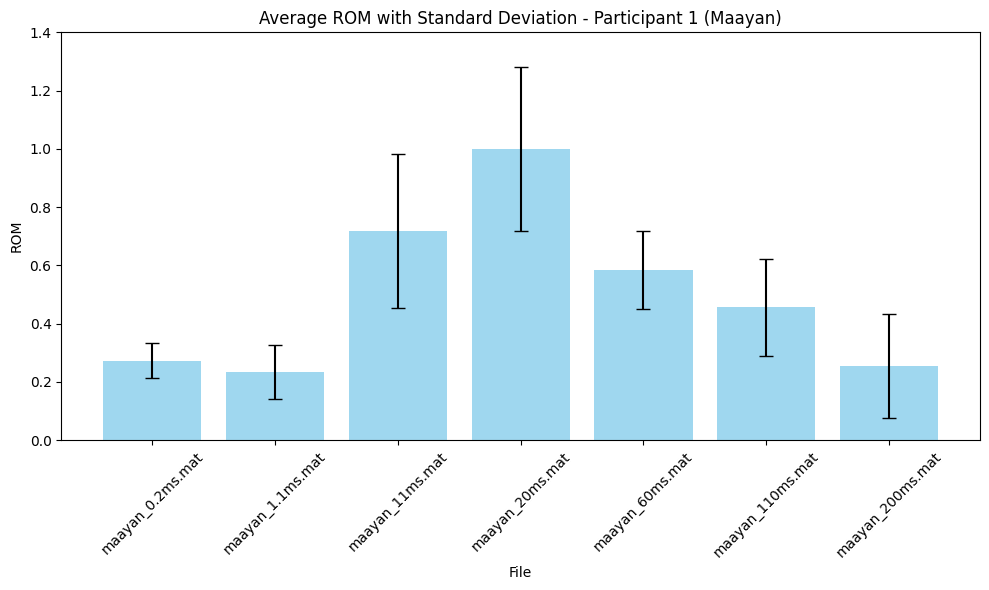


=== Processing for Participant 2 (Zohar) ===


,file,average_rom,std_rom
0,zohar_0.4ms.mat,0.070477,0.024599
1,zohar_1.2ms.mat,0.104332,0.058721
2,zohar_12ms.mat,0.605392,0.063109
3,zohar_20ms.mat,0.724589,0.084162
4,zohar_60ms.mat,0.403786,0.028515
5,zohar_120ms.mat,0.173378,0.021913
6,zohar_200ms.mat,0.094032,0.079648


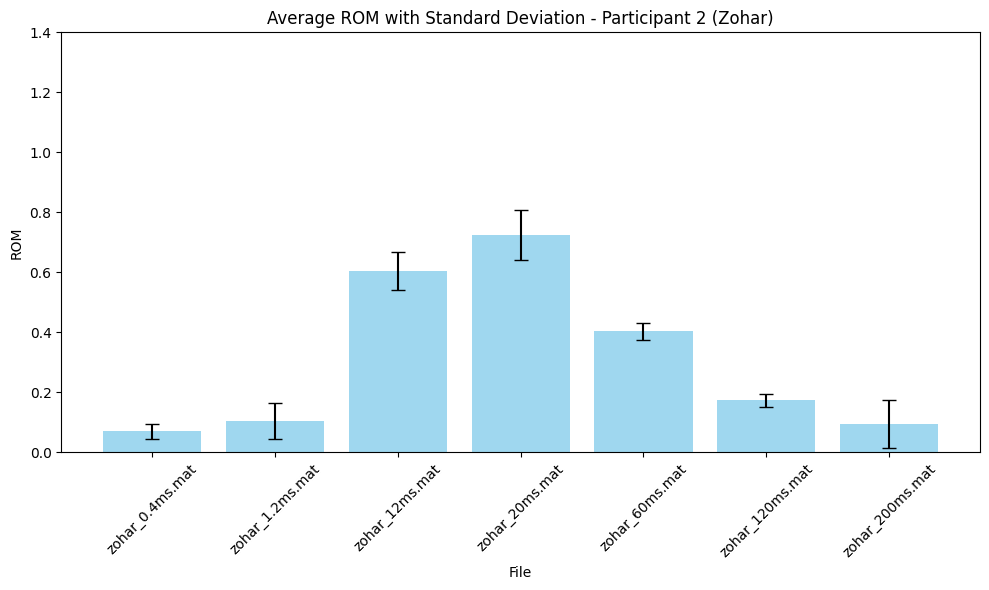

In [ ]:
import os
import re
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

def extract_delay(file_path):
    """
    Extracts the delay value from the filename.
    Assumes the filename contains a pattern like '_0.2ms'.
    """
    base_name = os.path.splitext(os.path.basename(file_path))[0]
    parts = base_name.split('_')
    if len(parts) < 2:
        return float('inf')
    delay_str = parts[-1]
    numeric_str = re.sub(r'[^0-9\.\-]', '', delay_str)
    try:
        return float(numeric_str)
    except ValueError:
        return float('inf')

def process_specific_file(file_path, threshold=5.0, pre_ms=100, post_ms=900, min_gap_ms=200):
    """
    Processes a single .mat file to analyze and calculate ROM values.
    """
    mat_dict = sio.loadmat(file_path, squeeze_me=True, struct_as_record=False)

    raw_data = mat_dict.get('data', None)
    labels = mat_dict.get('labels', None)
    isi = mat_dict.get('isi', None)

    if raw_data is None or not isinstance(raw_data, np.ndarray):
        return None

    # Convert labels to a list
    if isinstance(labels, np.ndarray):
        labels = labels.tolist()
    elif isinstance(labels, str):
        labels = [labels]

    # Identify Analog/Finger columns
    col_analog, col_finger = None, None
    if labels:
        for col_idx, lbl in enumerate(labels):
            lbl_lower = str(lbl).lower().strip()
            if 'analog' in lbl_lower or 'emg' in lbl_lower:
                col_analog = col_idx
            elif 'finger' in lbl_lower:
                col_finger = col_idx

    if (col_analog is None or col_finger is None) and raw_data.shape[1] >= 2:
        col_analog = 0
        col_finger = 1

    if col_analog is None or col_finger is None:
        return None

    analog_data = raw_data[:, col_analog]
    finger_data = raw_data[:, col_finger]

    # Create time axis
    if isi is not None:
        isi_val = isi.item() if isinstance(isi, np.ndarray) else isi
        time = np.arange(raw_data.shape[0]) * isi_val
    else:
        isi_val = 1.0  # Assume 1ms if isi is not provided
        time = np.arange(raw_data.shape[0])

    # Minimum gap in samples
    min_gap_samples = int(min_gap_ms / isi_val)

    # Detect pulses based on threshold crossing
    pulse_indices = np.where(np.diff(analog_data > threshold, prepend=False) > 0)[0]

    if len(pulse_indices) == 0:
        return None

    # Ensure only the first crossing per pulse is kept with a minimum gap
    filtered_pulse_indices = []
    for idx in pulse_indices:
        if not filtered_pulse_indices or (idx - filtered_pulse_indices[-1] >= min_gap_samples):
            filtered_pulse_indices.append(idx)

    filtered_pulse_indices = np.array(filtered_pulse_indices)

    # Initialize list to store ROM values
    rom_values = []

    # Process each pulse
    pre_samples = int(pre_ms / isi_val)
    post_samples = int(post_ms / isi_val)
    segment_length = pre_samples + post_samples

    for pulse_onset_idx in filtered_pulse_indices:
        # Calculate sample indices for pre/post time
        start_idx = max(pulse_onset_idx - pre_samples, 0)
        end_idx = min(pulse_onset_idx + post_samples, len(time)-1)

        # Segment the signals
        seg_finger = finger_data[start_idx:end_idx]

        # Ensure segment length matches
        if len(seg_finger) != segment_length:
            continue

        # Calculate ROM (range of motion)
        baseline = seg_finger[0]  # Value at pulse onset
        max_displacement = np.max(seg_finger)
        rom = max_displacement - baseline
        rom_values.append(rom)

    if len(rom_values) == 0:
        return None

    # Calculate average ROM and standard deviation
    avg_rom = np.mean(rom_values)
    std_rom = np.std(rom_values)

    return {
        "file": os.path.basename(file_path),
        "average_rom": avg_rom,
        "std_rom": std_rom
    }

def process_and_plot(files_to_process, threshold=5.0, pre_ms=100, post_ms=900, min_gap_ms=200):
    """
    Process files for each participant and plot results.
    """
    for participant, file_list in files_to_process.items():
        print(f"\n=== Processing for {participant} ===")
        rom_results = []
        for file_path in file_list:
            if os.path.exists(file_path):
                result = process_specific_file(file_path, threshold, pre_ms, post_ms, min_gap_ms)
                if result:
                    rom_results.append(result)
            else:
                print(f"File not found: {file_path}")

        if rom_results:
            # Convert results to DataFrame
            rom_df = pd.DataFrame(rom_results)

            # Display the DataFrame
            display(rom_df)

            # Plotting the results
            plt.figure(figsize=(10, 6))
            plt.bar(rom_df["file"], rom_df["average_rom"], yerr=rom_df["std_rom"], capsize=5, color='skyblue', alpha=0.8)
            plt.title(f"Average ROM with Standard Deviation - {participant}")
            plt.ylabel("ROM")
            plt.xlabel("File")
            plt.ylim(0, 1.4)  # Set fixed y-axis limit to 1.4
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

# Define files for each participant

files_to_process = {
    "Participant 1 (Maayan)": [
        "/content/maayan_0.2ms.mat",
        "/content/maayan_1.1ms.mat",
        "/content/maayan_11ms.mat",
        "/content/maayan_20ms.mat",
        "/content/maayan_60ms.mat",
        "/content/maayan_110ms.mat",
        "/content/maayan_200ms.mat",
    ],
    "Participant 2 (Zohar)": [
        "/content/zohar_0.4ms.mat",
        "/content/zohar_1.2ms.mat",
        "/content/zohar_12ms.mat",
        "/content/zohar_20ms.mat",
        "/content/zohar_60ms.mat",
        "/content/zohar_120ms.mat",
        "/content/zohar_200ms.mat",
    ]
}

# Run processing and plotting
process_and_plot(files_to_process, threshold=5.0, pre_ms=100, post_ms=900, min_gap_ms=200)
